# Time Series Analysis and Forecasting 

                                                                                        By: SAURABH GUPTA

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pylab as pyplot
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from sklearn.metrics import mean_squared_error

In [2]:
Airpassenger = pd.read_csv("AirPassengers.csv", header = 0, names = ['date', 'Passengers'],parse_dates = [0])
Airpassenger1 = Airpassenger.set_index('date')
Airpassenger.head()

,date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## Lets visualize our Air Passengers data - as it is!

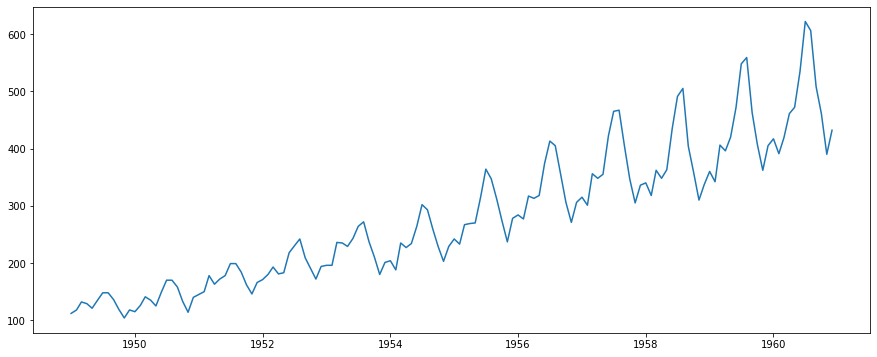

In [53]:
pyplot.plot(Airpassenger1)
pyplot.show()

## Lets visualize at Year-Quarterly levels

In [21]:
# Airpassenger["date"] = Airpassenger["date"].apply(lambda x: datetime.strptime(x, "%d-%m-%Y"))
Airpassenger["year"] = Airpassenger["date"].apply(lambda x: x.year)
Airpassenger["qtr"] = Airpassenger["date"].apply(lambda x: x.quarter)
Airpassenger["yearQtr"] = Airpassenger['year'].astype(str) + '_' + Airpassenger['qtr'].astype(str)
airPassengerByQtr = Airpassenger[["Passengers", "yearQtr"]].groupby(["yearQtr"]).sum()

In [22]:
airPassengerByQtr.head()

,Passengers
yearQtr,
1949_1,362
1949_2,385
1949_3,432
1949_4,341
1950_1,382


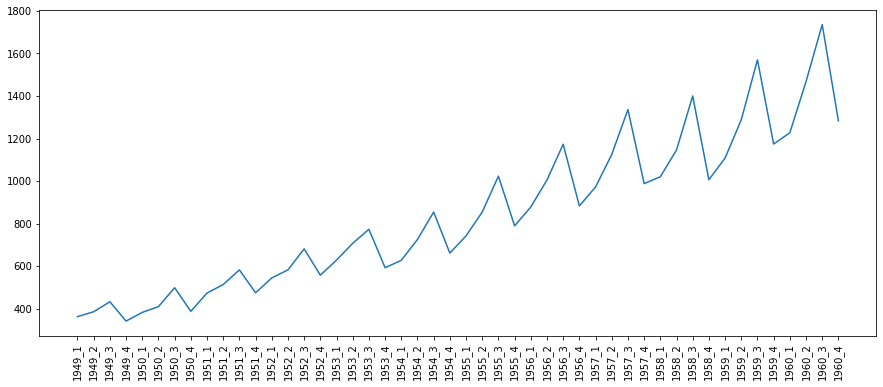

In [26]:
pyplot.plot(airPassengerByQtr)
pyplot.xticks(airPassengerByQtr.index, rotation='vertical')
pyplot.show()

### Naive method of shifting

In [92]:
Airpassenger = Airpassenger1.copy()

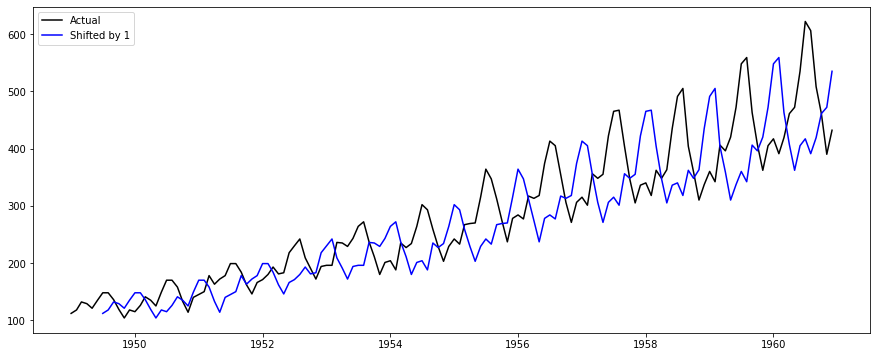

In [98]:
Airpassenger = Airpassenger.shift(1).dropna()
pyplot.plot(Airpassenger1,label='Actual',color='black')
pyplot.plot(Airpassenger,label='Shifted by 1',color='blue')
pyplot.legend()
pyplot.show()

### Simple Moving Averages - for different rolling windows

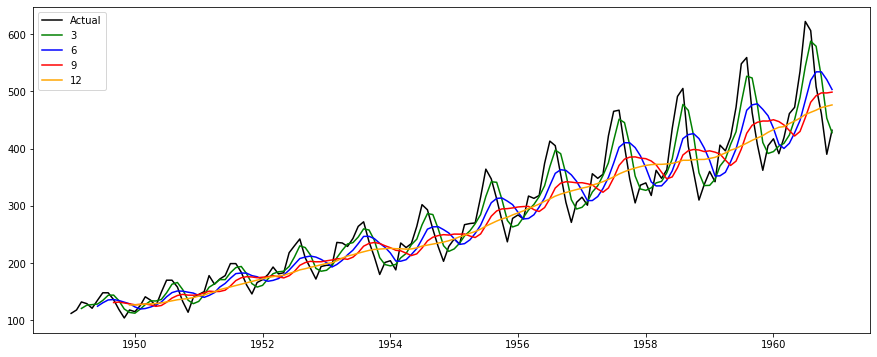

In [102]:
Airpassenger = Airpassenger1.copy()
# rolling average for different windows
months=[3,6,9,12]
colors=['green','blue','red','orange']
pyplot.plot(Airpassenger,label='Actual',color='black')
for i in range(len(months)):
    SMA=Airpassenger.rolling(window=months[i]).mean()
    pyplot.plot(SMA,label=months[i],color=colors[i])
pyplot.legend()
pyplot.show()

### Lets see Weighted Moving Averages (WMA)

In [76]:
weights = np.array([0.5, 0.25, 0.25])
sum_weights = np.sum(weights)

Airpassenger['WMA'] = (Airpassenger
    .rolling(window=3, center=True)
    .apply(lambda x: np.sum(weights*x) / sum_weights, raw=False)
)
# Airpassenger['date']=Airpassenger1.index
print(Airpassenger.dropna().head())

            Passengers     WMA
date                          
1949-02-01         118  118.50
1949-03-01         132  124.25
1949-04-01         129  128.50
1949-05-01         121  128.50
1949-06-01         135  131.25


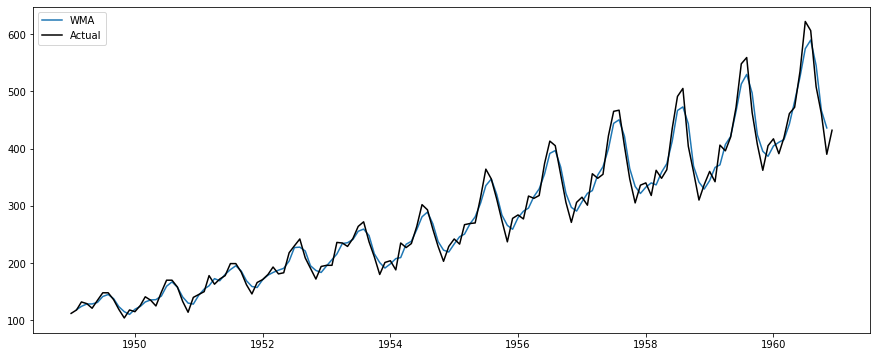

In [77]:
pyplot.plot(Airpassenger['WMA'].dropna(),label='WMA')
pyplot.plot(Airpassenger['Passengers'],color='black',label='Actual')
pyplot.legend()
pyplot.show()

### Now lets see Exponential Moving Average/Smoothing and forecast for next 12 months

#### BoxCox method of transformation is used here which has the purpose of normalising data to best fit and maximise likelihood

<AxesSubplot:title={'center':'Forecasts from Exponential Smoothing'}, xlabel='date', ylabel='Air Passengers'>

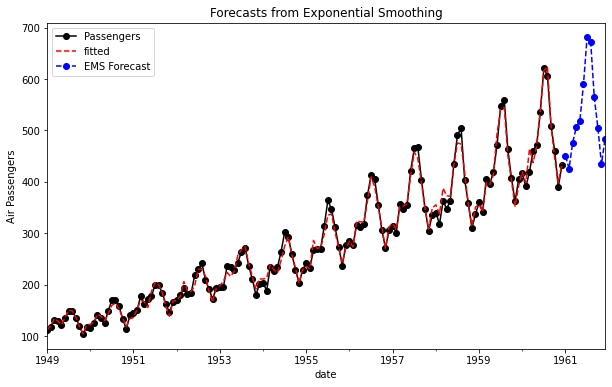

In [103]:
from statsmodels.tsa.api import ExponentialSmoothing
Airpassenger = Airpassenger1.copy()
EMA_fit = ExponentialSmoothing(Airpassenger, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)

ax = Airpassenger.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Exponential Smoothing" )
ax.set_ylabel("Air Passengers")
ax.set_xlabel("Index")

# For plotting fitted values
EMA_fit.fittedvalues.plot(ax=ax, style='--', color='red',label='fitted',legend=True)
# For plotting forecasted values
EMA_fit.forecast(12).rename('EMS Forecast').plot(ax=ax, style='--', marker='o', color='blue', legend=True)

### Next, lets see the usual decomposition

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
Airpassenger = Airpassenger1.copy()
decomposed = seasonal_decompose(Airpassenger, model='additive', period=12)

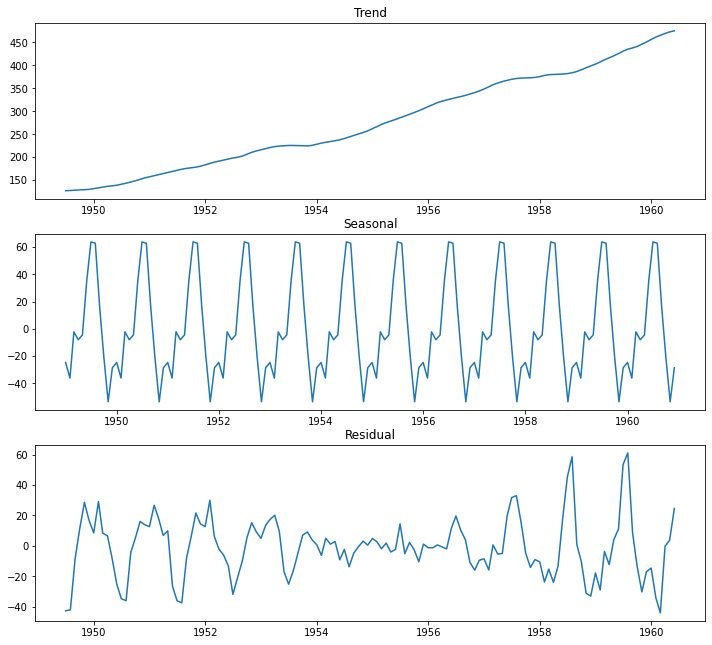

In [13]:
pyplot.rcParams['figure.figsize']=[12,11]
fig,ax=pyplot.subplots(3,1)
ax[0].plot(decomposed.trend)
ax[0].set_title("Trend")
ax[1].plot(decomposed.seasonal)
ax[1].set_title("Seasonal")
ax[2].plot(decomposed.resid)
ax[2].set_title("Residual")
pyplot.show()

### There's STL decomposition as well (preffered only for additive type series)

#### STL has been proven to give better seasonality decomosition, which we will see in below plot compared to above
It uses Loess regression method behind the scenes

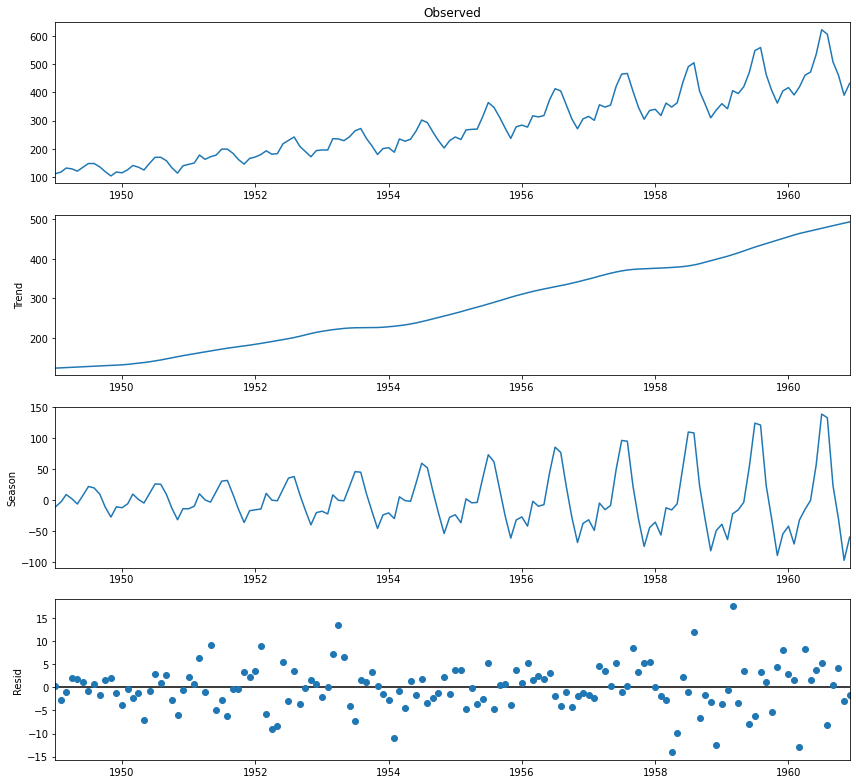

In [106]:
from statsmodels.tsa.seasonal import STL
STL_decomposed=STL(Airpassenger).fit()
STL_decomposed.plot()
pyplot.show()

## ACF,PACF and AdFuller tests

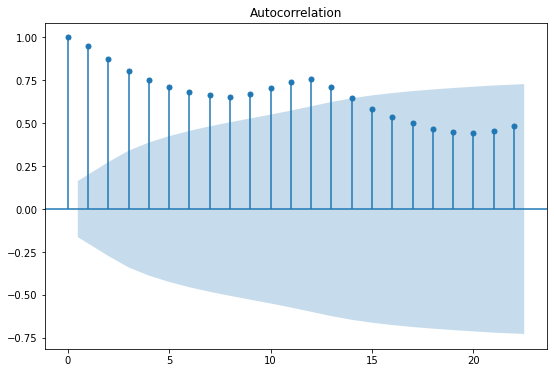

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
Airpassenger = Airpassenger1.copy()
plot_acf(Airpassenger)
pyplot.rcParams['figure.figsize']=[9,6]
pyplot.show()

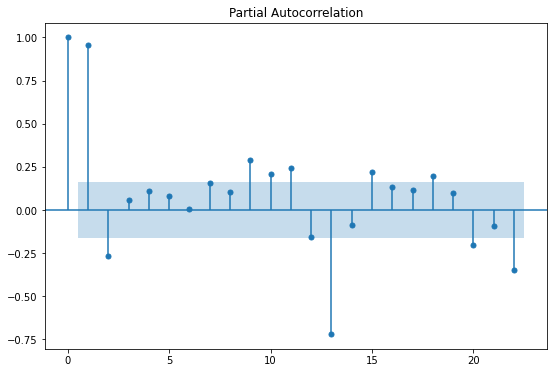

In [9]:
plot_pacf(Airpassenger)
pyplot.rcParams['figure.figsize']=[5,8]
pyplot.show()

### From above plots, we already realize that data is not stationary, still lets run adfuller test

In [17]:
from statsmodels.tsa.stattools import adfuller
adfuller(Airpassenger)

(0.8153688792060512,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

#### Log-shift transformation on data

In [15]:
log_air_passengers = np.log(Airpassenger.Passengers)
log_air_passengers[1:10]
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()
log_air_passengers_diff.dropna(inplace=True)
log_air_passengers_diff[1:10]

date
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
1949-08-01    0.000000
1949-09-01   -0.084557
1949-10-01   -0.133531
1949-11-01   -0.134733
Name: Passengers, dtype: float64

In [18]:
adfuller(log_air_passengers_diff)

(-2.7171305983881227,
 0.07112054815086045,
 14,
 128,
 {'1%': -3.4825006939887997,
  '5%': -2.884397984161377,
  '10%': -2.578960197753906},
 -440.35846985568105)

#### we can accept the stationarity at 10% level of significance, lets see the acf and pacf

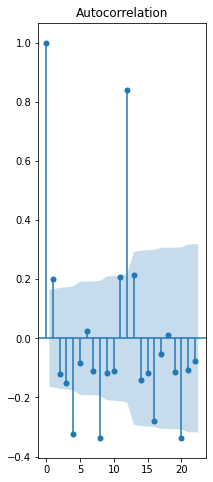

In [22]:
plot_acf(log_air_passengers_diff)
pyplot.rcParams['figure.figsize']=[3,8]
pyplot.show()

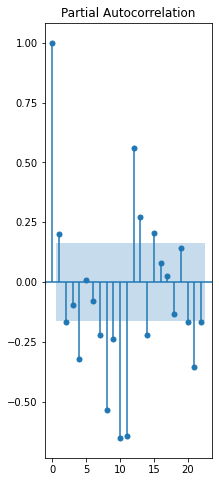

In [23]:
plot_pacf(log_air_passengers_diff)
pyplot.rcParams['figure.figsize']=[8,8]
pyplot.show()

#### NOTE :we do have seasonality

### Lets see the performance of AR, MA and ARIMA

In [25]:
from statsmodels.tsa.arima_model import ARIMA

Text(0.5, 1.0, 'AR model : RSS: 1.5023')

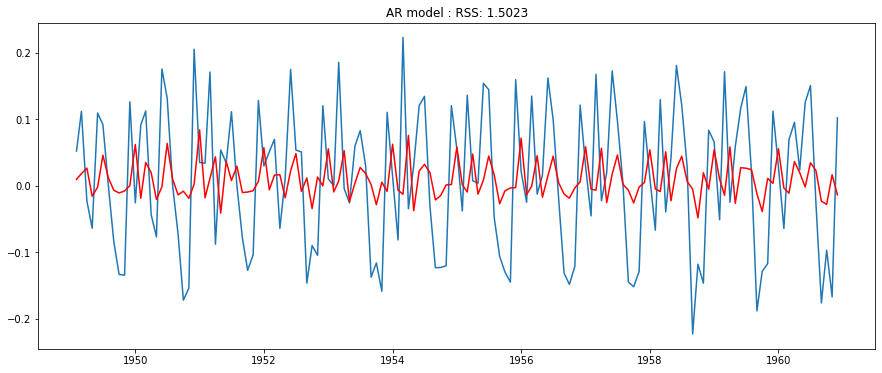

In [32]:
# AR model
model = ARIMA(log_air_passengers_diff, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
pyplot.plot(log_air_passengers_diff)
pyplot.plot(results_AR.fittedvalues, color='red')
pyplot.rcParams['figure.figsize']=[7,4]
pyplot.title('AR model : RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

Text(0.5, 1.0, 'MA model : RSS: 1.4721')

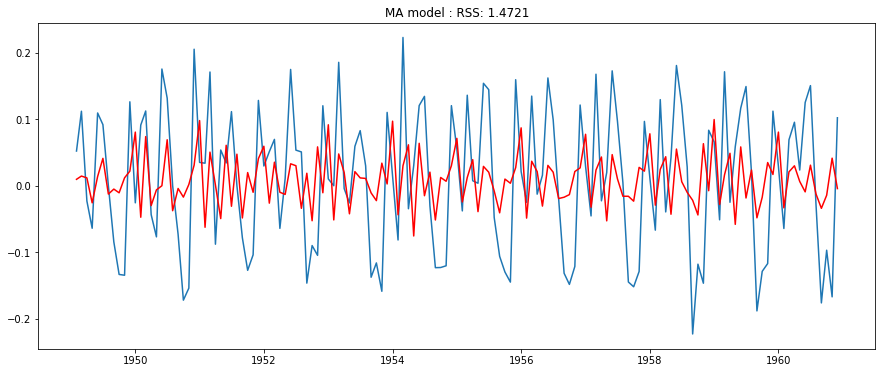

In [31]:
# MA model
model = ARIMA(log_air_passengers_diff, order=(0, 0, 2))  
results_MA = model.fit(disp=-1)  
pyplot.plot(log_air_passengers_diff)
pyplot.plot(results_MA.fittedvalues, color='red')
pyplot.title('MA model : RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

Text(0.5, 1.0, 'ARIMA model : RSS: 1.0292')

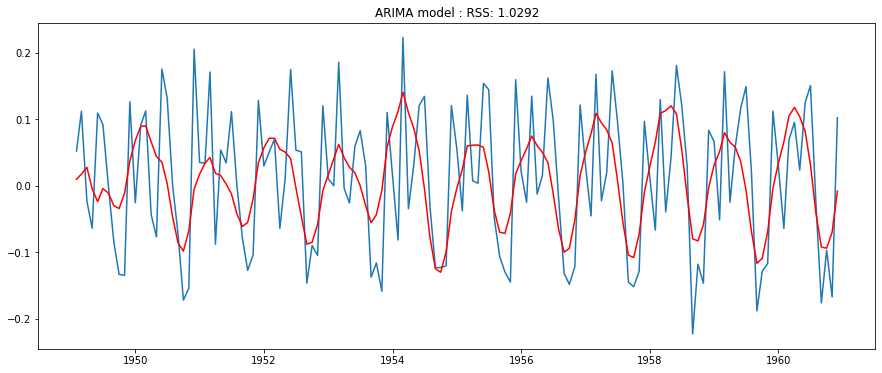

In [30]:
# ARIMA model
# model fit on non difference series to make place for D argument
model = ARIMA(log_air_passengers, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
pyplot.plot(log_air_passengers_diff)
pyplot.plot(results_ARIMA.fittedvalues, color='red')
pyplot.title('ARIMA model : RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

### Bringing data back to original form and visualize the model performance in usable numbers

In [39]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(log_air_passengers.iloc[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# predictions_ARIMA_log.head()

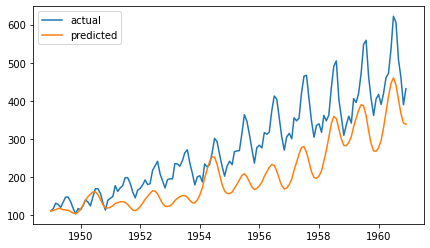

In [38]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
pyplot.plot(Airpassenger,label='actual')
pyplot.plot(predictions_ARIMA,label='predicted')
pyplot.legend()
pyplot.show()

## Lets see, if SARIMA can do better ! (remember, we have seen seasonality in data)

In [97]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(endog=log_air_passengers,order=(1,1,1),seasonal_order=(1,0,1,12),trend='c',enforce_invertibility=False)
results=model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 254.646
Date:                            Fri, 05 Feb 2021   AIC                           -497.292
Time:                                    16:23:39   BIC                           -479.515
Sample:                                01-01-1949   HQIC                          -490.068
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.814e-05    9.7e-05      0.599      0.549      -0.000       0.000
ar.L1          0.4975      0.148   

In [111]:
pred = results.get_prediction(start=pd.to_datetime('1955-01-01'), dynamic=True) 
# with dynamic = False, it can used to forecast one step at a time
pred_ci = pred.conf_int()

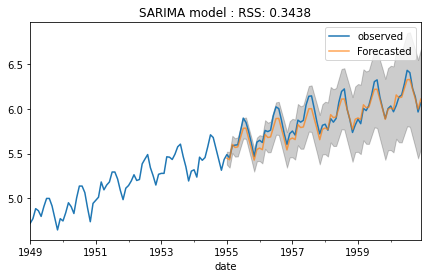

In [110]:
ax = log_air_passengers.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecasted', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
pyplot.title('SARIMA model : RSS: %.4f'% sum((pred.predicted_mean-log_air_passengers.iloc[-len(pred.predicted_mean):,])**2))
pyplot.legend()
pyplot.show()

### With range of forecast, its confidence intervals and a pretty good RSS score, we can rely on this model!
----------------------------------------------------------------

## Lets see some other methods which are used to capture volatility 
### Used to measure volatility at risk measures

## Entering ARCH and GARCH...


### Data of stock prices are quite volatile, hence fetching stock price data

In [114]:
import pandas_datareader as web
from pandas_datareader import data, wb
import datetime as dt

### We will be modelling on percent change of prices

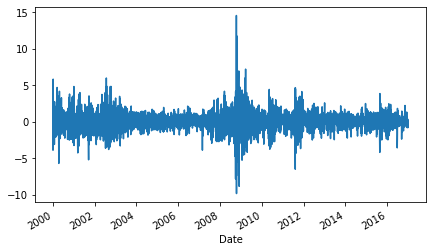

In [115]:
start = dt.datetime(2000,1,1)
end = dt.datetime(2017,1,1)
sp500 = web.get_data_yahoo('SPY', start=start, end=end)
returns = 100 * sp500['Close'].pct_change().dropna()
returns.plot()
pyplot.show()

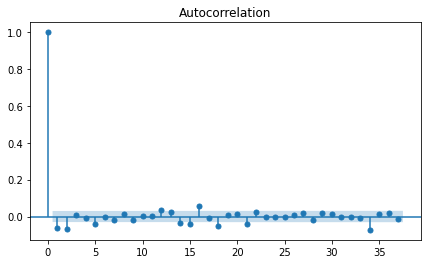

In [118]:
plot_acf(returns)
pyplot.show()

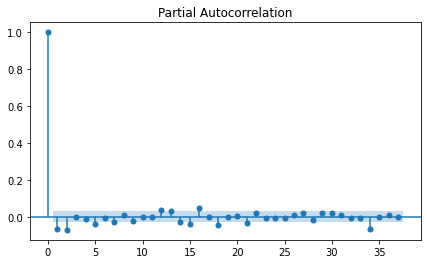

In [119]:
plot_pacf(returns)
pyplot.show()

In [116]:
from arch import arch_model

In [120]:
model=arch_model(returns, vol='Garch', p=2, o=0, q=2, dist='Normal')
results=model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 6051.446025344972
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6044.878131782845
Iteration:      3,   Func. Count:     33,   Neg. LLF: 6043.616924278995
Iteration:      4,   Func. Count:     43,   Neg. LLF: 6043.008990975266
Iteration:      5,   Func. Count:     52,   Neg. LLF: 6041.3263641504855
Iteration:      6,   Func. Count:     61,   Neg. LLF: 6039.500873880292
Iteration:      7,   Func. Count:     70,   Neg. LLF: 6038.8361579104185
Iteration:      8,   Func. Count:     79,   Neg. LLF: 6037.739398839885
Iteration:      9,   Func. Count:     88,   Neg. LLF: 6037.138857344082
Iteration:     10,   Func. Count:     97,   Neg. LLF: 6036.8679204708205
Iteration:     11,   Func. Count:    105,   Neg. LLF: 6036.784897745825
Iteration:     12,   Func. Count:    113,   Neg. LLF: 6036.770132202007
Iteration:     13,   Func. Count:    121,   Neg. LLF: 6036.770018169445
Iteration:     14,   Func. Count:    129,   Neg. LLF: 6036.76

### from above, we can expect 5.56% variation in prices per day

### Lets see Value at Risk for next 30 days

In [121]:
forecasts = results.forecast(horizon=30, method='simulation', simulations=1000)
sims = forecasts.simulations

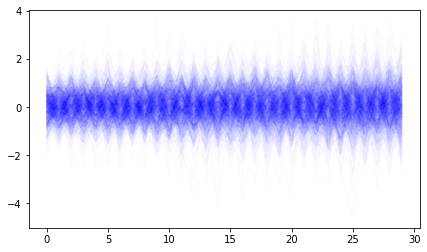

In [123]:
lines = pyplot.plot(sims.values[-1,:,:].T, color='blue', alpha=0.01)
lines[0].set_label('Simulated paths')
pyplot.show()

                                    -----     Thank You! -------